<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/llms-notebooks/02_fine_tuning_llamav2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

**Reference**

https://www.kdnuggets.com/fine-tuning-llamav2-with-qlora-on-google-colab-for-free

In [ ]:
!wget https://github.com/dozed/snli-german/raw/master/snli_1.0_train.csv

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [3]:
import pandas as pd
import os
import torch
from datasets import Dataset
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from huggingface_hub import notebook_login

##Data Preparation

In [4]:
data_df = pd.read_csv("snli_1.0_train.csv")
data_df.head()

,sentence1,sentence2,gold_label
0,Eine Person auf einem Pferd springt über ein z...,Eine Person trainiert ihr Pferd für ein Turnier.,neutral
1,Eine Person auf einem Pferd springt über ein z...,Eine Person ist in einem Diner und bestellt ei...,contradiction
2,Eine Person auf einem Pferd springt über ein z...,"Ein Mensch ist im Freien, auf einem Pferd.",entailment
3,Kinder lächeln und winken der Kamera zu.,Sie lächeln ihre Eltern an.,neutral
4,Kinder lächeln und winken der Kamera zu.,Es sind Kinder anwesend.,entailment


<Axes: >

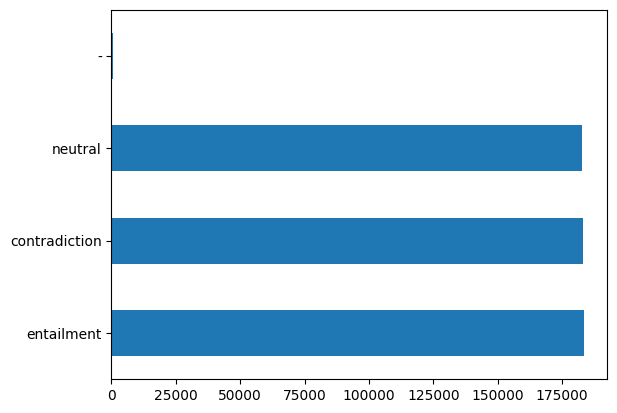

In [5]:
data_df["gold_label"].value_counts().plot(kind="barh")

In [6]:
# let's see a few random contradiction examples
data_df[data_df["gold_label"] == "contradiction"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
77657,Eine Band aller Frauen plant auf der Bühne und...,eine Band aller Frauen spielt im Gras und ein ...
365330,Menschen sitzen an einem Tisch mit Menüs und W...,Menschen stehen um einen Tisch bei einem Resta...
49658,Ein Mann in einem hawaiianischen Hemd spielt e...,Der Mann singt unter der Dusche.
298206,"Zwei Frauen spielen Instrumente, eines eine Kl...",Zwei Frauen spielen Gitarre und Schlagzeug.
19887,Ein Mann mit dunklen Schattierungen und seine ...,Die Tochter steht auf.
377015,"Eine blonde Frau, die auf einem Platz vor bunt...",Die Frau setzt sich hin.
441531,Der asiatische Mann bereitet panierte Shimps m...,Die Anwälte verdienen eine Menge Geld.
41332,"Eine Golferin in roten Hosen, einer schwarz-we...",Die Frau fährt einen Berg hinunter.
85757,"Graues Pferd mit blauer Decke, das von einem o...",Das Graue Pferd trank Wasser.
453143,Ein Mann hackt eine Zwiebel in der Küche.,Der Mann sitzt.


In [7]:
# let's see a few random entailment examples
data_df[data_df["gold_label"] == "entailment"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
283617,Leute gehen eine Gasse entlang.,Die Leute gehen.
514176,"Ein kleiner Junge, der von einem Sprungbrett i...",Ein Junge springt in den Pool.
334448,Junge Frauen machen eine Pause vom Einkaufen.,Frauen machen Pausen.
549582,Ein Bauarbeiter in einem grauen Hemd und einer...,ein Arbeiter hockt in der Nähe eines Eimers un...
215992,Ein Mädchen mit Sonnenbrille wirft eine Zitron...,"Da ist ein Mädchen, das mit einer Zitrone spielt."
204105,ein schwarzer Hund spritzt im Wasser.,Der Hund fiel ins Wasser.
497696,3 kleine Jungen mit Netzen laufen in einem Park.,Einige Jungen tragen Netze im Park.
278897,Zwei kleine Jungs arbeiten an einem kleinen Fa...,Das Fahrrad wird gerade bearbeitet.
163199,Ein Paar Hände schießt eine schwarze Waffe in ...,Jemand schießt draußen.
483590,Eine Frau in einem weißen Outfit hält ihre Han...,Die Frau trägt weiß.


In [8]:
# let's see a few random neutral examples
data_df[data_df["gold_label"] == "neutral"].sample(10)[["sentence1", "sentence2"]]

,sentence1,sentence2
186994,Ein Mann steht hinter einem Podium.,Der Mann hält eine Rede vom Podium.
502851,Ein Mann mit einem dunklen Hut und einer braun...,"Es gab keinen Stuhl um den Mann herum, also en..."
167721,"Ein übergewichtiger Mann, der in der Kabine ei...","Ein alter Mann, der in einem alten Lastwagen i..."
125994,Ein Mann mit roten Schattierungen hält eine Lö...,Ein Künstler skulptiert eine Metallstatue eine...
409409,"eine Frau, die auf ihrem kleinen Appartementde...",Eine Frau beobachtet den Sonnenuntergang.
137760,eine Doppelbelichtung eines lachenden Babys mi...,Das Baby lacht über einen Cartoon.
488354,Zwei Frauen in blauer Kleidung gehen mit dem R...,Zwei Weibchen gehen lachend davon.
24735,Ein Mann mit rotem Kragen und grauem Bart scha...,Ein Mann posiert für ein Foto mit seiner Familie.
424544,Eine Gruppe von Kindern und ihr Vormund gehen ...,Tolle Menschen beim Gehen
438037,Eine schwarz gekleidete Barista macht hinter e...,Eine Barista Frau macht Kaffee für einen sehr ...


In [9]:
# let's takes only the contradictory sentences and converts the dataset instruct format
def convert_to_instruct_format(row):
  sentence1 = row["sentence1"]
  sentence2 = row["sentence1"]

  prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
  instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
  input = str(sentence1)
  response = f"""```json{{'orignal_sentence':'sentence1', 'generated_negation':'sentence2'}}```"""

  if len(input.strip()) == 0:
    # prompt + 2 new lines + ###instruction + new line + input + new line + ###response
    text = prompt + "\n\n Instruction:\n" + instruction + "\n### Response:\n" + response
  else:
    text = prompt + "\n\n Instruction:\n" + instruction + "\n### Input:\n" + "\n" + "\n### Response:\n" + response

  # we need 4 columns for auto train, instruction, input, output, text
  return pd.Series([instruction, input, response, text])

In [10]:
new_df = data_df[data_df["gold_label"] == "contradiction"][["sentence1", "sentence2"]].apply(convert_to_instruct_format, axis=1)
new_df.columns = ["instruction", "input", "output", "text"]
new_df.to_csv("snli_instruct.csv", index=False)

In [11]:
new_df.head()

,instruction,input,output,text
1,"Given the following sentence, your job is to g...",Eine Person auf einem Pferd springt über ein z...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
5,"Given the following sentence, your job is to g...",Kinder lächeln und winken der Kamera zu.,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
6,"Given the following sentence, your job is to g...",Ein Junge springt auf dem Skateboard in der Mi...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
10,"Given the following sentence, your job is to g...",Ein älterer Mann sitzt mit seinem Orangensaft ...,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...
13,"Given the following sentence, your job is to g...",Zwei blonde Frauen umarmen sich gegenseitig.,"```json{'orignal_sentence':'sentence1', 'gener...",Below is an instruction that describes a task ...


In [12]:
# let's load the formatted dataset
df = pd.read_csv("snli_instruct.csv")

In [13]:
# let's convert it to the Hugging Face dataset format
dataset = Dataset.from_pandas(df)

##Fine-tuning

We will be using the already quantized LLamav2 model.

In [14]:
# The model that you want to train from the Hugging Face hub
model_name = "abhishek/llama-2-7b-hf-small-shards"

# Fine-tuned model name
fine_tuned_model = "llama-2-contradictor"

################################################################################
#                      QLoRA parameters
################################################################################
# LoRA attention dimension
lora_r = 64
# Alpha parameter for LoRA scaling
lora_alpha = 16
# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
#                     bitsandbytes parameters
################################################################################
# Activate 4-bit precision base model loading
use_4bit = True
# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"
# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"
# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
#                   TrainingArguments parameters
################################################################################
# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"
# Number of training epochs
num_train_epochs = 1
# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False
# Batch size per GPU for training
per_device_train_batch_size = 4
# Batch size per GPU for evaluation
per_device_eval_batch_size = 4
# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1
# Enable gradient checkpointing
gradient_checkpointing = True
# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3
# Initial learning rate (AdamW optimizer)
learning_rate = 1e-5
# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001
# Optimizer to use
optim = "paged_adamw_32bit"
# Learning rate schedule
lr_scheduler_type = "cosine"
# Number of training steps (overrides num_train_epochs)
max_steps = 1500
# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03
# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True
# Save checkpoint every X updates steps
save_steps = 0
# Log every X updates steps
logging_steps = 100

################################################################################
#                         SFT parameters
################################################################################
# Maximum sequence length to use
max_seq_length = None
# Pack multiple short examples in the same input sequence to increase efficiency
packing = False
# Load the entire model on the GPU 0
device_map = {"":0}

In [15]:
# let's use BitsAndBytesConfig class to create the config for 4-bit fine-tuning
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant
)

In [ ]:
# let's load the base model with 4 bit BitsAndBytesConfig and tokenizer for Fine-Tuning
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(model_name,
                                             quantization_config=bnb_config,
                                             device_map=device_map)
model.config.use_cache = False
model.config.pretraining_tp = 1

We can now create the LoRA config and set the training parameters.

In [17]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

Now we can simply use SFTTrainer which is provided by from HuggingFace to start the training.

In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text", # this is the text column in dataset
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing
)

# Train model
trainer.train()

In [19]:
# Save trained model
trainer.model.save_pretrained(fine_tuned_model)

##Push model to hub

In [ ]:
notebook_login()

In [23]:
model.push_to_hub("rahiakela/llama-2-contradictor",
                  use_auth_token=True,
                  commit_message="basic training",
                  private=False)

In [20]:
# let's build zip
!zip -r llama-contradictor.zip results llama-contradictor

	zip warning: name not matched: llama-contradictor
  adding: results/ (stored 0%)
  adding: results/runs/ (stored 0%)
  adding: results/runs/Dec27_09-56-30_4d92cc2a8875/ (stored 0%)
  adding: results/runs/Dec27_09-56-30_4d92cc2a8875/events.out.tfevents.1703671044.4d92cc2a8875.348.0 (deflated 63%)


In [21]:
!mkdir fine_tuned_model
!unzip llama-contradictor.zip -d fine_tuned_model/

Archive:  llama-contradictor.zip
   creating: fine_tuned_model/results/
   creating: fine_tuned_model/results/runs/
   creating: fine_tuned_model/results/runs/Dec27_09-56-30_4d92cc2a8875/
  inflating: fine_tuned_model/results/runs/Dec27_09-56-30_4d92cc2a8875/events.out.tfevents.1703671044.4d92cc2a8875.348.0  


You need to load the base model again and merge it with the fine-tuned LoRA matrices.

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0}
)


model = PeftModel.from_pretrained(base_model, "fine_tuned_model/llama-contradictor")
model = model.merge_and_unload()

lima_pipeline = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=200
)

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

OutOfMemoryError: ignored

##Inference

You can test your model by simply passing in the inputs in the same prompt template.

In [ ]:
prompt_template = """
### Instruction: Given the following sentence, your job is to generate the negation for it in the json format
### Input:
{}

### Response:
"""

sentence = "The weather forecast predicts a sunny day with a high temperature around 30 degrees Celsius, perfect for a day at the beach with friends and family."
input_sentence = prompt_template.format(sentence.strip())
result = lima_pipeline(input_sentence)
print(result)